# Making Predictions

Model loaded successfully from /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPE/Models/mean/no2/All_Stations/no2_Forecasting_Models/model_booster.txt and /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPE/Models/mean/no2/All_Stations/no2_Forecasting_Models/model_params.json


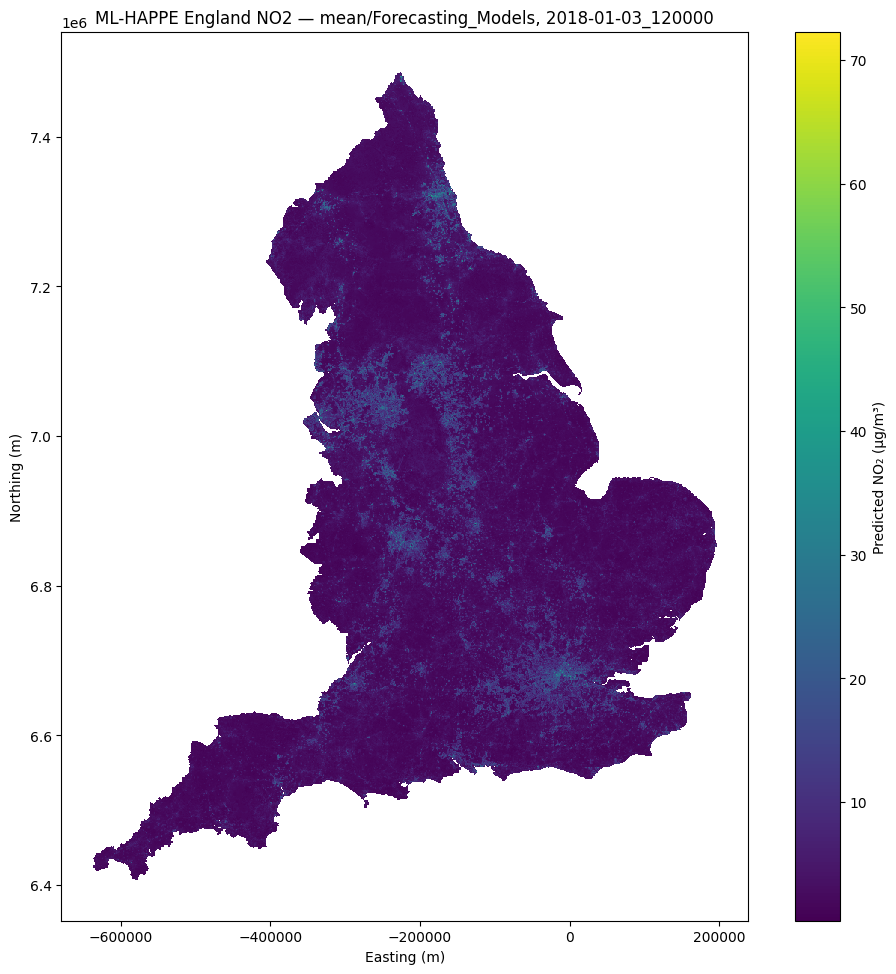

In [1]:
# ========= ML-HAPPE (UK) — NO2 =========
# Predict & map UK NO2 for a given timestamp like "YYYY-MM-DD_HHmmss"
# Output PNGs are saved to environmental_insights/environmental_insights_visulisations/

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import lightgbm as lgb

from environmental_insights import air_pollution_functions as ei_air_pollution_functions
from environmental_insights import data as ei_data
from environmental_insights import models as ei_models
from environmental_insights import download as ei_download
from environmental_insights import variables as ei_vars

# ----------------------------
# SETTINGS
# ----------------------------
pollutant = "no2"
model_level = "mean"
uk_timestamp = "2018-01-03_120000"  # <- underscore format accepted here

# Model category used for ML-HAPPE
uk_model_category = "Forecasting_Models"

# ----------------------------
# 1) Fetch INPUT features at the timestamp
# ----------------------------
X_uk = ei_data.air_pollution_concentration_complete_set_real_time_united_kingdom(
    uk_timestamp, data_type="Input"
)

# ----------------------------
# 2) Load the model & select features
# ----------------------------
uk_model = ei_models.load_model_united_kingdom(
    model_level=model_level,
    pollutant=pollutant,
    model_category=uk_model_category,
)
uk_features = ei_models.get_model_feature_vector("Forecasting")

# ----------------------------
# 3) Predict (returned in concentration units)
# ----------------------------
uk_pred = ei_models.make_concentration_predictions_united_kingdom(
    uk_model, X_uk, uk_features
)  # -> ["UK_Model_Grid_ID", "Model Prediction"]

# ----------------------------
# 4) Join to UK grid polygons
# ----------------------------
uk_grids = ei_data.get_uk_grids()
uk_map = uk_grids.merge(uk_pred, on="UK_Model_Grid_ID", how="left")

# ----------------------------
# 5) Plot full polygons instead of scatter points
# ----------------------------
uk_map_gdf = gpd.GeoDataFrame(uk_map, geometry="geometry", crs="EPSG:27700")

fig, ax = plt.subplots(figsize=(10, 10))
uk_map_gdf.plot(
    ax=ax,
    column="Model Prediction",
    cmap="viridis",
    linewidth=0,
    legend=True,
    legend_kwds={"label": f"Predicted {ei_vars.replacePollutantName.get(pollutant, pollutant.upper())} (μg/m³)"},
)

ax.set_title(f"ML-HAPPE England {pollutant.upper()} — {model_level}/{uk_model_category}, {uk_timestamp}")
ax.set_xlabel("Easting (m)")   # EPSG:27700 X
ax.set_ylabel("Northing (m)")  # EPSG:27700 Y
ax.set_aspect("equal")         # keep metres square, no flip/distortion
plt.tight_layout()
plt.show()

Model loaded successfully from /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPG/Models/mean/temporal/o3/model_booster.txt and /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPG/Models/mean/temporal/o3/model_params.json


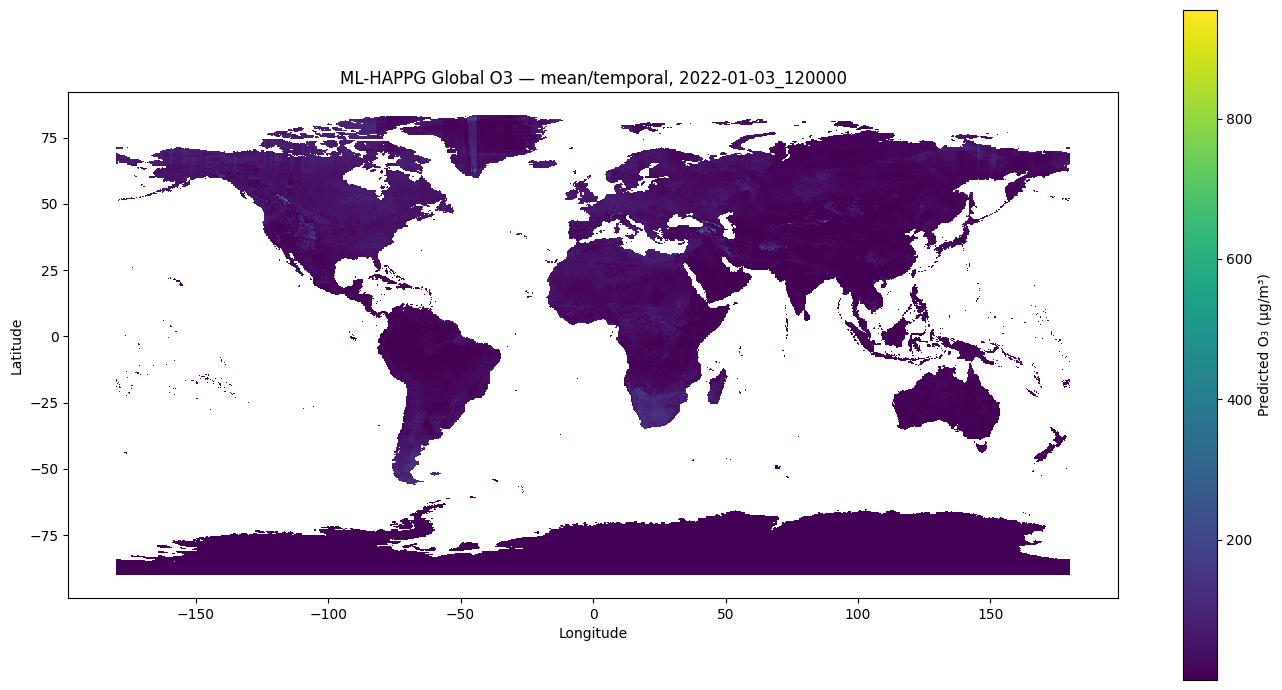

In [2]:
# ========= ML-HAPPG (GLOBAL) — O3 =========
# Predict & map global O3 for a given timestamp like "YYYY-MM-DD_HHmmss"
# Plot global model grid polygons in EPSG:4326

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import lightgbm as lgb

from environmental_insights import data as ei_data
from environmental_insights import models as ei_models
from environmental_insights import variables as ei_vars  # pretty pollutant label

# ----------------------------
# SETTINGS
# ----------------------------
pollutant = "o3"
model_level = "mean"
global_timestamp = "2022-01-03_120000"  # <- underscore format
model_category = "temporal"             # ML-HAPPG temporal path
token = None

# ----------------------------
# 1) Fetch GLOBAL INPUT features at the timestamp
# ----------------------------
X_g = ei_data.air_pollution_concentration_complete_set_real_time_global(
    global_timestamp, data_type="Input"
)  # flat DataFrame keyed by Global_Model_Grid_ID

# ----------------------------
# 2) Rename columns to what the GLOBAL model expects
# ----------------------------
X_g = ei_models.rename_global_input_columns(X_g)

# ----------------------------
# 3) Load the GLOBAL model (Temporal → special layout in ML-HAPPG)
# ----------------------------
g_model = ei_models.load_model_global(
    model_level=model_level,
    pollutant=pollutant,
    model_category=model_category,
    token=token
)

# ----------------------------
# 4) Select features FROM THE MODEL (not variables.py)
# ----------------------------
if isinstance(g_model, lgb.Booster):
    booster = g_model
elif hasattr(g_model, "booster_") and isinstance(g_model.booster_, lgb.Booster):
    booster = g_model.booster_
elif hasattr(g_model, "_Booster") and isinstance(g_model._Booster, lgb.Booster):
    booster = g_model._Booster
else:
    raise RuntimeError("Could not access LightGBM Booster to read feature names.")

model_features = list(booster.feature_name())
feature_names = [f for f in model_features if f in X_g.columns]
if not feature_names:
    raise KeyError("No overlap between model features and input columns.")

# ----------------------------
# 5) Predict using the GLOBAL helper (returns ['Global_Model_Grid_ID','Model Prediction'])
# ----------------------------
g_pred = ei_models.make_concentration_predictions_global(
    estimating_model=g_model,
    observation_data=X_g,
    feature_names=feature_names
)

# ----------------------------
# 6) Join to GLOBAL grid polygons (EPSG:4326) and plot the grid
# ----------------------------
global_grids = ei_data.get_global_grids()  # geometry in EPSG:4326
global_map = global_grids.merge(g_pred, on="Global_Model_Grid_ID", how="left")

global_map_gdf = gpd.GeoDataFrame(global_map, geometry="geometry", crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(14, 7))
global_map_gdf.plot(
    ax=ax,
    column="Model Prediction",
    cmap="viridis",
    linewidth=0,
    legend=True,
    legend_kwds={
        "label": f"Predicted {ei_vars.replacePollutantName.get(pollutant, pollutant.upper())} (μg/m³)"
    },
)

ax.set_title(f"ML-HAPPG Global {pollutant.upper()} — {model_level}/{model_category}, {global_timestamp}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


Downloaded: https://dap.ceda.ac.uk/badc/deposited2025/ML-HAPPE/Models/0.5/pm10/All_Stations/pm10_Transport_Infrastructure_Models/model_booster.txt -> /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPE/Models/0.5/pm10/All_Stations/pm10_Transport_Infrastructure_Models
Downloaded: https://dap.ceda.ac.uk/badc/deposited2025/ML-HAPPE/Models/0.5/pm10/All_Stations/pm10_Transport_Infrastructure_Models/model_params.json -> /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPE/Models/0.5/pm10/All_Stations/pm10_Transport_Infrastructure_Models
Model loaded successfully from /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPE/Models/0.5/pm10/All_Stations/pm10_Transport_Infrastructure_Models/model_booster.txt and /Users/lb788/Documents/EI/Environmental-Insights/environmental_insights/environmental_insights_models/ML-HAPPE/Model

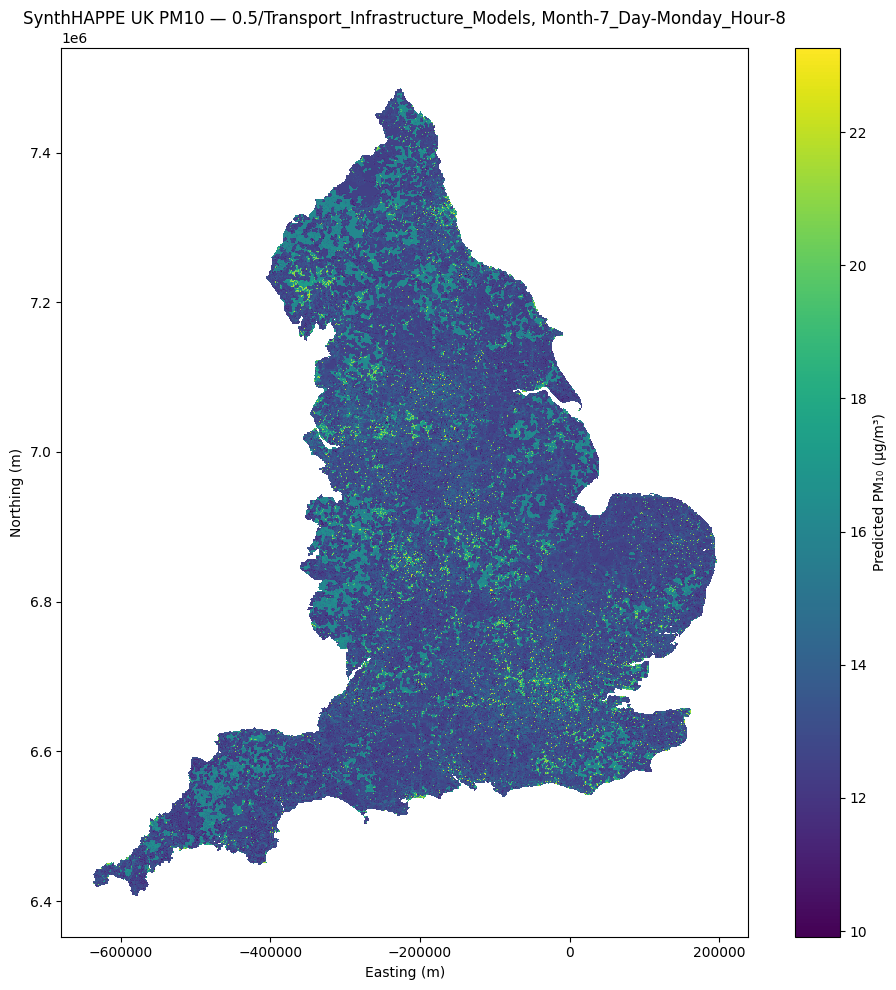

In [4]:
# ========= SynthHAPPE (UK Typical-Day) — PM10 =========
# Predict & map UK PM10 for a (Month, DayOfWeek, Hour) slice
# Plot grid polygons in native EPSG:27700 (British National Grid)

import geopandas as gpd
import matplotlib.pyplot as plt

from environmental_insights import data as ei_data, models as ei_models
from environmental_insights import variables as ei_vars  # for pretty pollutant label

# ----------------------------
# SETTINGS
# ----------------------------
pollutant = "pm10"
model_level = "0.5"

# Choose a typical-day slice
month = 7                # July
day_of_week = "Monday"
hour = 8                 # 08:00

# SynthHAPPE categories: "Climate_Projections_Models" or "Transport_Infrastructure_Policy_Models"
synth_category = "Transport_Infrastructure_Models"

# ----------------------------
# 1) Fetch SynthHAPPE INPUT features for that slice
# ----------------------------
X_synth = ei_data.air_pollution_concentration_typical_day_real_time_united_kingdom(
    month=month, day_of_week=day_of_week, hour=hour, data_type="Input"
)

# ----------------------------
# 2) Load the model (UK loader auto-switches under-the-hood for SynthHAPPE categories)
# ----------------------------
synth_model = ei_models.load_model_united_kingdom(
    model_level=model_level,
    pollutant=pollutant,
    model_category=synth_category,
)
synth_features = ei_models.get_model_feature_vector("Transport Infrastructure")

# ----------------------------
# 3) Predict (concentration units) & join to UK grid polygons
# ----------------------------
synth_pred = ei_models.make_concentration_predictions_united_kingdom(
    synth_model, X_synth, synth_features
)  # -> ["UK_Model_Grid_ID", "Model Prediction"]

synth_map = ei_data.get_uk_grids().merge(synth_pred, on="UK_Model_Grid_ID", how="left")

# ----------------------------
# 4) Plot grid polygons in EPSG:27700 (no reprojection)
# ----------------------------
label_stub = f"Month-{month}_Day-{day_of_week}_Hour-{hour}"

synth_map_gdf = gpd.GeoDataFrame(synth_map, geometry="geometry", crs="EPSG:27700")

fig, ax = plt.subplots(figsize=(10, 10))
synth_map_gdf.plot(
    ax=ax,
    column="Model Prediction",
    cmap="viridis",
    linewidth=0,
    legend=True,
    legend_kwds={
        "label": f"Predicted {ei_vars.replacePollutantName.get(pollutant, pollutant.upper())} (μg/m³)"
    },
)

ax.set_title(f"SynthHAPPE UK {pollutant.upper()} — {model_level}/{synth_category}, {label_stub}")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect("equal")  # keep metres square, correct orientation
plt.tight_layout()
plt.show()
